In [54]:
%matplotlib inline
from matplotlib import pyplot as plt 
import time 
import numpy as np

from mxnet import gluon
from mxnet import init
from mxnet import nd, autograd

ImportError: cannot import name 'nn'

In [6]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)
print(len(mnist_train), len(mnist_test))

60000 10000


In [17]:
feature, label = mnist_train[0]
print(feature.shape, feature.dtype, label.shape, label.dtype)

(28, 28, 1) <class 'numpy.uint8'> () int32


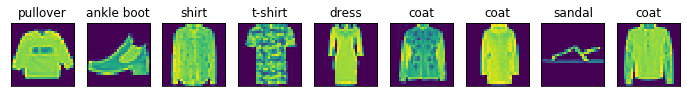

In [27]:
def get_fashion_mnist_label_name(labels):
    label_names = ["t-shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    return [label_names[int(i)] for i in labels]

def show_fashion_mnist(images, label_names):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, label_name in zip(figs, images, label_names):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(label_name)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
X, y = mnist_train[:9]
show_fashion_mnist(X, get_fashion_mnist_label_name(y))

In [33]:
batch_size = 256
num_workers = 4
transformer = gluon.data.vision.transforms.ToTensor()

train_iter = gluon.data.DataLoader(
    mnist_train.transform_first(transformer),
    batch_size, 
    shuffle=True, 
    num_workers=num_workers
)
test_iter = gluon.data.DataLoader(
    mnist_test.transform_first(transformer),
    batch_size, 
    shuffle=True, 
    num_workers=num_workers
)


In [51]:
num_inputs = 28*28
num_outputs = 10

W = nd.random.normal(0, 0.01, (num_inputs, num_outputs))
b = nd.zeros(num_outputs)

W.attach_grad()
b.attach_grad()

def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition 

def net(X):
    return softmax(nd.dot(X.reshape(-1, num_inputs), W) + b)

def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype("float32")
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size
    return 

def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for ep in range(1, num_epochs+1):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch {}, loss {}, train acc {}, test acc {}'.format(ep, train_l_sum / n, train_acc_sum / n, test_acc))
    return 

num_epochs = 5
lr = 0.1
train(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7879334794362386, train acc 0.7464166666666666, test acc 0.8069
epoch 2, loss 0.5748650268554687, train acc 0.8097, test acc 0.8185
epoch 3, loss 0.5291120805104573, train acc 0.8226166666666667, test acc 0.8307
epoch 4, loss 0.5048215926806132, train acc 0.82945, test acc 0.8352
epoch 5, loss 0.48953177134195963, train acc 0.8348333333333333, test acc 0.8398


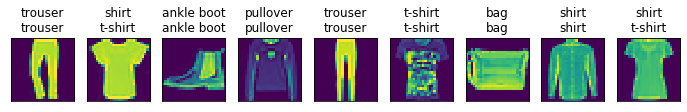

In [52]:
for X, y in test_iter:
    break
    
true_labels = get_fashion_mnist_label_name(y.asnumpy())
pred_labels = get_fashion_mnist_label_name(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[:9], titles[:9])

In [57]:
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

loss = gluon.loss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

num_epochs = 5
train(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 0.7904994148254395, train acc 0.7444, test acc 0.7967
epoch 2, loss 0.5730381748199463, train acc 0.8105166666666667, test acc 0.8229
epoch 3, loss 0.5300916395823161, train acc 0.8233333333333334, test acc 0.8298
epoch 4, loss 0.505244182395935, train acc 0.82985, test acc 0.8322
epoch 5, loss 0.4890098051071167, train acc 0.8339, test acc 0.8426
